# `01` Import Necessary Libraries

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
from sklearn.model_selection import train_test_split , GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler , RobustScaler
from sklearn.preprocessing import OneHotEncoder , LabelEncoder
from sklearn.linear_model import LinearRegression , SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

----------------------------

# `02` Load Data

In [2]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [3]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


## `#` Create Test Set

Before exploring the data, let's split the data into training and test sets.

In [4]:
housing.dropna(subset=["total_bedrooms"], inplace=True)
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [5]:
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, random_state=1234)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(17368, 9)
(17368,)
(3065, 9)
(3065,)


----------------

# `03` Exploratory Data Analysis (EDA)

## `i` Simple Analysis

In [6]:
data = housing.copy()
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
data.info(verbose = True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [8]:
data["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

## `ii` Visual Analysis

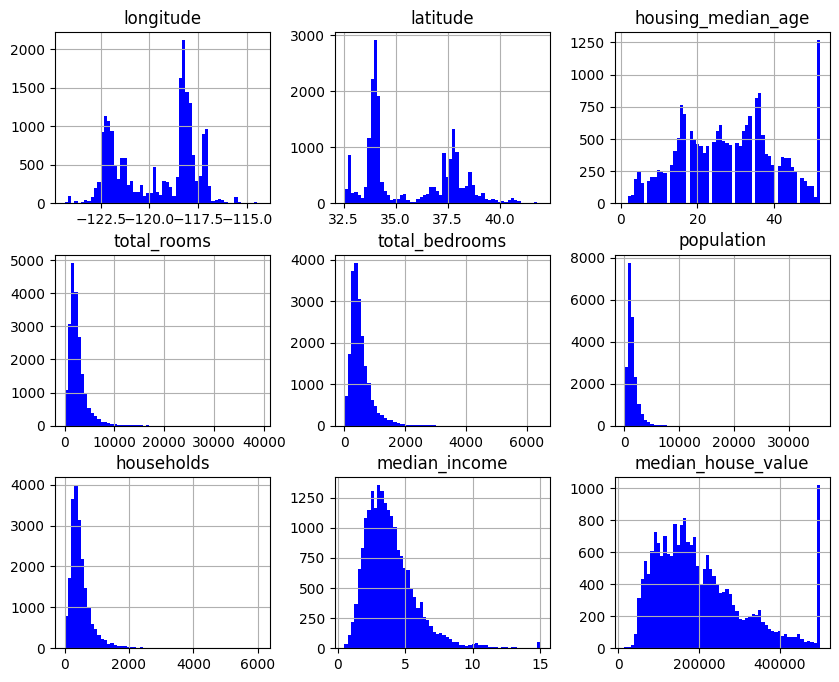

In [9]:
data.hist(bins=60, figsize=(10,8),color="blue");plt.show()

ocean_proximity
<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: count, dtype: int64


<Axes: xlabel='ocean_proximity'>

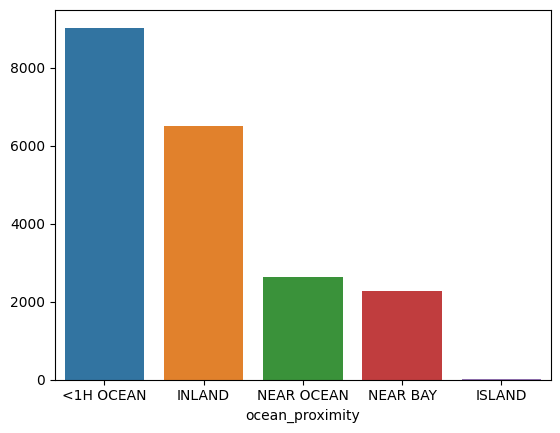

In [10]:
ocean = data["ocean_proximity"].value_counts()
print(ocean)
sns.barplot(x=ocean.index, y=ocean.values, hue = ocean.index)

In [11]:
Le = LabelEncoder()
data["ocean_proximity"] = Le.fit_transform(data["ocean_proximity"])
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,1
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,1
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,1
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,1


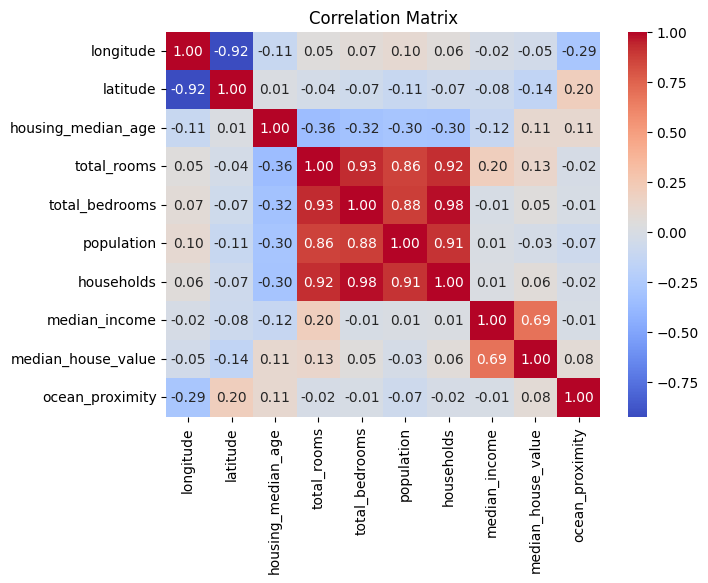

In [12]:
correlation_matrix = data.corr()
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Strong corelation between </br>
- total bedrooms and total rooms </br>
- population and total rooms </br>
- house holds and total bedrooms </br>
- house holds  and population </br>
- median income and median house value

----------------

# `04` Data Preparation

In [13]:
# total bedrooms and total rooms are very coralated
# remove total_bedrooms beacuse it is the one with nulls
#X_train = X_train.drop(columns=["total_bedrooms"])
#X_train.shape

In [14]:
print(X_train["ocean_proximity"].dtype)

object


In [15]:
X_train["ocean_proximity"] = X_train["ocean_proximity"].astype(str)
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_train_encoded = encoder.fit_transform(X_train[["ocean_proximity"]])
encoded_feature_names = encoder.get_feature_names_out(["ocean_proximity"])
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_train_num = X_train.drop(columns=["ocean_proximity"])
X_train = pd.concat([X_train_num, X_train_encoded], axis=1)

X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
6574,-118.15,34.11,52.0,2375.0,369.0,930.0,351.0,7.4111,1.0,0.0,0.0,0.0,0.0
16976,-117.24,32.75,33.0,1980.0,614.0,1057.0,567.0,2.2042,0.0,0.0,0.0,0.0,1.0
13142,-117.65,34.07,52.0,1041.0,252.0,558.0,231.0,1.9236,0.0,1.0,0.0,0.0,0.0
10506,-117.71,33.60,25.0,1949.0,459.0,602.0,428.0,2.7601,1.0,0.0,0.0,0.0,0.0
5508,-120.22,39.20,22.0,8259.0,1409.0,845.0,353.0,3.3699,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8304,-117.41,33.93,35.0,793.0,150.0,669.0,128.0,4.0156,0.0,1.0,0.0,0.0,0.0
9544,-117.31,33.24,6.0,1580.0,288.0,792.0,265.0,4.0469,1.0,0.0,0.0,0.0,0.0
8556,-116.95,33.79,8.0,10997.0,2205.0,5060.0,1949.0,2.1979,0.0,1.0,0.0,0.0,0.0
17228,-117.20,34.04,23.0,1762.0,267.0,1132.0,279.0,5.9915,0.0,1.0,0.0,0.0,0.0


In [16]:
scaler = RobustScaler(with_centering=True, with_scaling=True)
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
6574,0.092348,-0.039578,1.210526,0.152917,-0.182336,-0.247533,-0.173375,1.770518,1.0,0.0,0.0,0.0,0.0
16976,0.332454,-0.398417,0.210526,-0.079847,0.515670,-0.112030,0.495356,-0.615205,0.0,0.0,0.0,0.0,1.0
13142,0.224274,-0.050132,1.210526,-0.633176,-0.515670,-0.644439,-0.544892,-0.743772,0.0,1.0,0.0,0.0,0.0
10506,0.208443,-0.174142,-0.210526,-0.098114,0.074074,-0.597493,0.065015,-0.360500,1.0,0.0,0.0,0.0,0.0
5508,-0.453826,1.303430,-0.368421,3.620212,2.780627,-0.338224,-0.167183,-0.081099,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8304,0.287599,-0.087071,0.315789,-0.779316,-0.806268,-0.526007,-0.863777,0.214751,0.0,1.0,0.0,0.0,0.0
9544,0.313984,-0.269129,-1.210526,-0.315557,-0.413105,-0.394772,-0.439628,0.229092,1.0,0.0,0.0,0.0,0.0
8556,0.408971,-0.124011,-1.105263,5.233648,5.048433,4.158976,4.773994,-0.618091,0.0,1.0,0.0,0.0,0.0
17228,0.343008,-0.058047,-0.315789,-0.208309,-0.472934,-0.032009,-0.396285,1.120079,0.0,1.0,0.0,0.0,0.0


## `#` Prepare Test Set

In [17]:
#X_test = X_test.drop(columns=["total_bedrooms"])

X_test["ocean_proximity"] = X_test["ocean_proximity"].astype(str)
X_test_encoded = encoder.transform(X_test[["ocean_proximity"]])
encoded_feature_names = encoder.get_feature_names_out(["ocean_proximity"])
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)
X_test_num = X_test.drop(columns=["ocean_proximity"])
X_test = pd.concat([X_test_num, X_test_encoded], axis=1)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

X_test


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.113456,-0.113456,-0.631579,1.594873,2.094017,2.887170,2.198142,-0.434863,1.0,0.0,0.0,0.0,0.0
1,-0.567282,1.060686,-0.421053,0.577195,0.706553,0.190984,0.430341,-0.645445,0.0,1.0,0.0,0.0,0.0
2,-0.868074,0.989446,-0.631579,1.129346,1.085470,0.626300,0.653251,-0.171407,0.0,1.0,0.0,0.0,0.0
3,0.295515,-0.052770,-0.631579,0.603123,0.387464,0.480128,0.337461,-0.086963,0.0,1.0,0.0,0.0,0.0
4,0.174142,-0.137203,-0.368421,2.331467,3.900285,3.790878,3.897833,-0.188589,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3060,0.029024,-0.031662,-0.526316,1.744549,1.712251,0.916511,1.712074,0.926175,1.0,0.0,0.0,0.0,0.0
3061,-0.902375,0.992084,-0.684211,-0.162345,-0.222222,0.134436,-0.213622,0.302310,0.0,1.0,0.0,0.0,0.0
3062,-0.955145,0.907652,-0.526316,0.223630,0.575499,0.436383,0.532508,-0.441507,0.0,0.0,0.0,1.0,0.0
3063,0.382586,-0.329815,-0.526316,0.850029,0.441595,0.295545,0.529412,0.493969,1.0,0.0,0.0,0.0,0.0


----------------------------

# `05` Linear Regression

## `i` Model Training

In [18]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## `ii` Model Evaluation

Evaluate model performance using several metrics, e.g. **RMSE**, **MAE**, $R^2$. etc.

In [19]:
pred = model.predict(X_test)
metrics = {
    "mean_squared_error": mean_squared_error(y_test, pred),
    "mean_absolute_error": mean_absolute_error(y_test, pred),
    "r2_score": r2_score(y_test, pred)
}

for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

mean_squared_error: 4637232394.93
mean_absolute_error: 49730.83
r2_score: 0.64



# `06` Linear Regression with Gradient Descent

## `i` Baseline Model Training
with :
- Non-regularized model.
- Constant `learning_rate`

In [20]:
model = SGDRegressor(learning_rate='constant', penalty=None)
model.fit(X_train, y_train)

SGDRegressor(learning_rate='constant', penalty=None)

## `ii` Model Evaluation

Evaluate the baseline model performance using several metrics, e.g. **RMSE**, **MAE**, $R^2$. etc.

In [21]:
pred = model.predict(X_test)
metrics = {
    "mean_squared_error": mean_squared_error(y_test, pred),
    "mean_absolute_error": mean_absolute_error(y_test, pred),
    "r2_score": r2_score(y_test, pred)
}

for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

mean_squared_error: 4744802957.52
mean_absolute_error: 50737.68
r2_score: 0.63


## `iii` Tune `learning_rate`

Try different learning rate

In [22]:
param_grid = {
    'eta0': [0.0001, 0.001, 0.01, 0.1, 1]
}

model = SGDRegressor(learning_rate='constant', penalty=None) 
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

r2 = r2_score(y_test, grid_search.predict(X_test))
print(f"r2_score: {r2:.2f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ........................................eta0=0.0001; total time=   0.0s
[CV] END ........................................eta0=0.0001; total time=   0.0s
[CV] END ........................................eta0=0.0001; total time=   0.0s
[CV] END ........................................eta0=0.0001; total time=   0.0s
[CV] END ........................................eta0=0.0001; total time=   0.0s
[CV] END .........................................eta0=0.001; total time=   0.0s
[CV] END .........................................eta0=0.001; total time=   0.0s
[CV] END .........................................eta0=0.001; total time=   0.0s
[CV] END .........................................eta0=0.001; total time=   0.0s
[CV] END .........................................eta0=0.001; total time=   0.0s
[CV] END ..........................................eta0=0.01; total time=   0.0s
[CV] END ........................................

In [23]:
param_dist = {
    'eta0': [0.0001, 0.001, 0.01, 0.1, 1] 
}

model = SGDRegressor(learning_rate='constant', penalty=None)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=5, verbose=2)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
pred = best_model.predict(X_test)

r2 = r2_score(y_test, pred)

print("Best parameters:", random_search.best_params_)
print(f"r2_score: {r2:.4f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ........................................eta0=0.0001; total time=   0.0s
[CV] END ........................................eta0=0.0001; total time=   0.0s
[CV] END ........................................eta0=0.0001; total time=   0.0s
[CV] END ........................................eta0=0.0001; total time=   0.0s
[CV] END ........................................eta0=0.0001; total time=   0.0s
[CV] END .........................................eta0=0.001; total time=   0.0s
[CV] END .........................................eta0=0.001; total time=   0.0s
[CV] END .........................................eta0=0.001; total time=   0.0s
[CV] END .........................................eta0=0.001; total time=   0.0s
[CV] END .........................................eta0=0.001; total time=   0.0s
[CV] END ..........................................eta0=0.01; total time=   0.0s
[CV] END ........................................

## `iv` Regularization Mode: On

Let's try $l_1$ and $l_2$ regularization.

In [24]:
param_grid = {
    'eta0': [0.0001, 0.001, 0.01, 0.1, 1],
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1],
}

model = SGDRegressor(learning_rate='constant', penalty="l1") 
grid_search = GridSearchCV(estimator=model, param_grid=param_grid)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

model = SGDRegressor(learning_rate='constant', penalty="l2") 
grid_search = GridSearchCV(estimator=model, param_grid=param_grid)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'alpha': 0.1, 'eta0': 0.001}
Best parameters: {'alpha': 0.001, 'eta0': 0.001}


In [25]:
param_dist = {
    'eta0': [0.0001, 0.001, 0.01, 0.1, 1],
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1],
}

model = SGDRegressor(learning_rate='constant', penalty="l1")
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=5)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
pred = best_model.predict(X_test)

r2 = r2_score(y_test, pred)

print("Best parameters:", random_search.best_params_)

model = SGDRegressor(learning_rate='constant', penalty="l2")
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=5)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
pred = best_model.predict(X_test)

r2 = r2_score(y_test, pred)

print("Best parameters:", random_search.best_params_)

Best parameters: {'eta0': 0.001, 'alpha': 0.1}
Best parameters: {'eta0': 0.0001, 'alpha': 0.001}


------------------

# `07` Generalization Error


In [26]:
# the best model is the one with l2 penalty {'alpha': 0.0001, 'eta0': 0.001}
model = SGDRegressor(learning_rate='constant', penalty="l2", alpha=0.0001, eta0=0.001)
model.fit(X_train, y_train)
pred = model.predict(X_test)
r2 = r2_score(y_test, pred)
print(f"r2_score: {r2:.4f}")

r2_score: 0.6404


-----------------------------

# Better Flow

For the model to be production-ready, we need to integrate it into a pipeline along with the data preparation flow.

In [41]:
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, random_state=1234)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(17368, 9)
(17368,)
(3065, 9)
(3065,)


In [42]:
categorical_features = ["ocean_proximity"] 
numerical_features = X_train.drop(columns=categorical_features).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_features),
        ("scaler", RobustScaler(), numerical_features),])

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", SGDRegressor(learning_rate='constant', penalty="l2", alpha=0.0001, eta0=0.001)) 
    ]
)

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['ocean_proximity']),
                                                 ('scaler', RobustScaler(),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income'])])),
                ('regressor',
                 SGDRegressor(eta0=0.001, learning_rate='constant'))])

In [43]:
pred = model.predict(X_test)
r2 = r2_score(y_test, pred)
print(f"r2_score: {r2:.4f}")

r2_score: 0.6401
